# Computer Vision - Fashion MNIST
The current repository contains a common task within the scope of Computer Vision field: Image Detection. Other similar projects can be found in the following repositories:

- [MNIST](https://github.com/UribeAlejandro/ComputerVision_MNIST)
- [CIFAR10](https://github.com/UribeAlejandro/ComputerVision_CIFAR10)
- [Cats vs Dogs](https://github.com/UribeAlejandro/ComputerVision_Cats_vs_Dogs)
- [Rock Paper & Scissors](https://github.com/UribeAlejandro/ComputerVision_Rock_Paper_or_Scissors)

## Fashion MNIST
The *Fashion-MNIST* dataset contains 70,000 labeled article images. Each image is a 28×28 grayscale image, associated with a label from 10 classes. 

Further information about the dataset can be found in the following webpages:  
[Fashion MNIST - Kaggle](https://www.kaggle.com/zalando-research/fashionmnist)  
[Fashion MNIST - Zalando Research](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/)  
[Fashion MNIST - Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/fashion_mnist)


*All the datasets used along this notebook are open sourced.*

## Libraries & Modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Modelling
import tensorflow as tf
from tensorflow import keras

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## User Defined Functions

In [2]:
def plot_images(images_data,labels_data):
    fig, axes = plt.subplots(1, 8,figsize=(14,2))
    images_and_labels = list(zip(images_data[:8], labels_data[:8]))
    for ax, (image, label) in zip(axes, images_and_labels):
        image = image.reshape(28,28)
        ax.set_axis_off()
        ax.imshow(image, cmap = 'binary')
        ax.set_title(f'Label: {label}')

In [3]:
class accuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.998):
            print("\nReached 99.8% accuracy so cancelling training!\n")
            self.model.stop_training = True

## Fashion MNIST
The classification task will be tackled using *Convolutional Neural Networks - CNN* and will use two different datasets:
- Uncompressed Images
- Compressed Images using PCA

Each approach listed above has advantages &amp; disadvantages, that will be explained further in the *Error Analysis* section.

### Data Loading
Keras provides the Datasets API which allows the user to fetch open-sourced datasets, such as MNIST and Fashion MNIST. Firstly, we will use it to load the MNIST dataset. The MNIST contains:
- *Images* that corresponds to *70,000 examples* of *28x28* and is denoted as `X`.
- *Labels* that corresponds to a column vector which contains the *70,000* corresponding labels and is denoted as `y`.


\begin{equation*}
X = 
\begin{bmatrix}
x_{0,0} & \cdots & x_{0,27}\\
\vdots & \vdots & \vdots\\
x_{27,0} & \cdots & x_{27,27}\\
\end{bmatrix}_{70000\times 28 \times 28}
\quad
\quad
y = 
\begin{bmatrix}
y_{0,0}\\
\vdots\\
\vdots\\
\vdots\\
\vdots\\
\vdots\\
y_{69999,0}\\
\end{bmatrix}_{7000\times 1}
\end{equation*}

The Keras Datasets API splits the data into `training` &amp; `test` examples. It assigns *60,000* examples for `training` and *10,000* examples for `test`.

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


Let's check the type of the pixels in images and labels.

In [5]:
print(f'Pixels Training images type: {type(training_images[0][0][0])}')
print(f'Training labels type: {type(training_labels[0])}')
print(f'Pixels Test images type: {type(test_images[0][0][0])}')
print(f'Test labels type: {type(test_labels[0])}')

Pixels Training images type: <class 'numpy.uint8'>
Training labels type: <class 'numpy.uint8'>
Pixels Test images type: <class 'numpy.uint8'>
Test labels type: <class 'numpy.uint8'>


The pixels in images are *int8*, they will casted to *float32*.

In [6]:
training_images, test_images = training_images.astype('float32'), test_images.astype('float32')

print(f'Pixels Training images type: {type(training_images[0][0][0])}')
print(f'Pixels Test images type: {type(test_images[0][0][0])}')

Pixels Training images type: <class 'numpy.float32'>
Pixels Test images type: <class 'numpy.float32'>


The pixels will be rescaled, it will be a value between [0-1], this will improve the training process, because it reduces training time.

In [7]:
training_images, test_images = training_images / 255.0, test_images / 255.0

Let's check their dimensions.

In [8]:
print(f'Training images shape: {training_images.shape}')
print(f'Training labels shape: {training_labels.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Test labels shape: {test_labels.shape}')

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


The `labels` variables correspond to a *rank-1 array*, that is *(70000, )* in total. Also the `images` should be reshaped to *(70000,28,28,1)* in order to specify that there is only one color channel.

In [9]:
training_images = training_images.reshape(60000,28,28,1)
test_images = test_images.reshape(10000,28,28,1)

Some examples of the images are shown below.

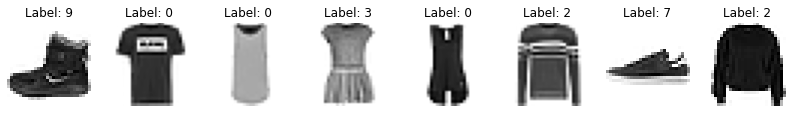

In [10]:
plot_images(training_images,training_labels)

Each label is mapped to a label, the labels are in the table below.

|Class|Label|
|:---:|:----|
|0|T-shirt/top|
|1|Trouser|
|2|Pullover|
|3|Dress|
|4|Coat|
|5|Sandal|
|6|Shirt|
|7|Sneaker|
|8|Bag|
|9|Ankle boot|

The balance of different classes in the `target` variable will be checked as follows.

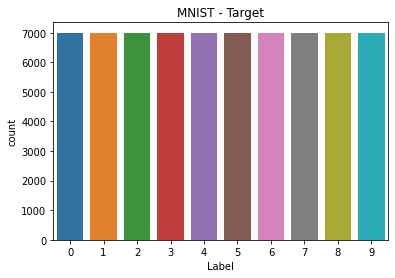

In [11]:
sns.countplot(np.concatenate((training_labels, test_labels), axis=0))
plt.title('MNIST - Target')
plt.xlabel('Label')
plt.show()

The dataset will be split into *Train &amp; Validation sets*, the *Validation set* will correspond to the *10%* of the total examples.

In [12]:
val_images = training_images[50000:]
val_labels = training_labels[50000:]

training_images = training_images[:50000]
training_labels = training_labels[:50000]

Let's check the shapes after split.

In [13]:
print(f'Training images shape: {training_images.shape}')
print(f'Training labels shape: {training_labels.shape}')
print(f'Validation images shape: {val_images.shape}')
print(f'Validation labels shape: {val_labels.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Test labels shape: {test_labels.shape}')

Training images shape: (50000, 28, 28, 1)
Training labels shape: (50000,)
Validation images shape: (10000, 28, 28, 1)
Validation labels shape: (10000,)
Test images shape: (10000, 28, 28, 1)
Test labels shape: (10000,)


The pixels in images correspond to a number between *[0 - 255]*, then the pixels will be rescaled as follows:

### Modelling
This phase will follow two approaches, both using the same *Convolutional Neural Network architecture*:
- Uncompressed images.
- Compressed images using PCA.

The architecture of the current Convolutional layer is shown below:

![CNN](./assets/CNN.svg)

The *accuracy* is the metric used to evaluate the performance of the model, the accuracy is defined as follows:

\begin{equation*}
accuracy\; =\; \dfrac{Number\; of\; correct\; predictions}{Total\; number\; of\; predictions}
\end{equation*}


#### Uncompressed Images
This approach will use rescaled images without any compression for *training*, *validation* &amp; *test* steps.

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'softmax')])

The method *compile()* allows us to define the optimizer, the loss function, metrics, and other parameters if necessary.

In [15]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

The method *summary()* provides an information about the parameters of each layer and the shape of their outputs.

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               204928    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

Let's use the 
```python
class accuracyCallback()
```
to create a callback which will stop trainining the model once the *accuracy* reaches *99.8%*, which is quite high but the overfiting will be checked in the **Error Analysis** section.

In [17]:
accCallback = accuracyCallback()

The *fit()* method will train the model and the history of this step will be stored in the `history` variable in order to save the information to carry out the **Error Analysis** later. The model will be trained in *20 epochs*, but we expect to reach *99.8% accuracy* before the 15<sup>th</sup> epoch.

In [18]:
history = model.fit(training_images, training_labels,
                      validation_data = (val_images, val_labels),
                      callbacks = [accCallback],epochs = 20, verbose = 2)

Epoch 1/20
1563/1563 - 5s - loss: 0.4668 - accuracy: 0.8297 - val_loss: 0.3601 - val_accuracy: 0.8679
Epoch 2/20
1563/1563 - 5s - loss: 0.3022 - accuracy: 0.8905 - val_loss: 0.3160 - val_accuracy: 0.8866
Epoch 3/20
1563/1563 - 5s - loss: 0.2582 - accuracy: 0.9049 - val_loss: 0.2808 - val_accuracy: 0.8953
Epoch 4/20
1563/1563 - 5s - loss: 0.2276 - accuracy: 0.9162 - val_loss: 0.2519 - val_accuracy: 0.9081
Epoch 5/20
1563/1563 - 5s - loss: 0.1987 - accuracy: 0.9252 - val_loss: 0.2497 - val_accuracy: 0.9069
Epoch 6/20
1563/1563 - 5s - loss: 0.1731 - accuracy: 0.9356 - val_loss: 0.2473 - val_accuracy: 0.9110
Epoch 7/20
1563/1563 - 5s - loss: 0.1522 - accuracy: 0.9441 - val_loss: 0.2815 - val_accuracy: 0.9056
Epoch 8/20
1563/1563 - 5s - loss: 0.1355 - accuracy: 0.9489 - val_loss: 0.2612 - val_accuracy: 0.9159
Epoch 9/20
1563/1563 - 5s - loss: 0.1179 - accuracy: 0.9547 - val_loss: 0.2876 - val_accuracy: 0.9087
Epoch 10/20
1563/1563 - 5s - loss: 0.1019 - accuracy: 0.9623 - val_loss: 0.2926 - 

The model reached the 99.8% accuracy in less than 15 epoch and now let's check it's performance over the test set.

In [19]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.4955 - accuracy: 0.9025


[0.4954860806465149, 0.9024999737739563]

99.1% test set accuracy, with this result we can tell that there was no overfiting.

### Error Analysis

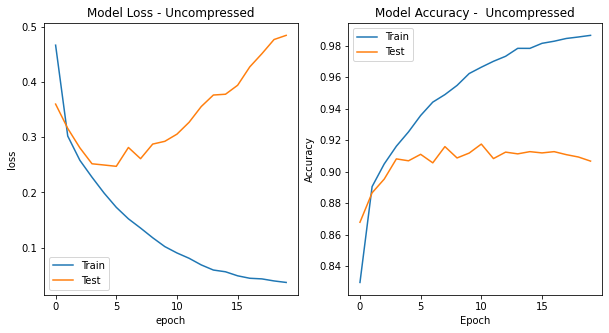

In [21]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss - Uncompressed')
ax[0].legend(['Train', 'Test'], loc = 'best')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy -  Uncompressed')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Test'], loc = 'best')

plt.show()